In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

API_KEY = None
SECRET_KEY = None

import os
from dotenv import load_dotenv

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [2]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

from alpaca.trading.client import TradingClient
from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.corporate_actions import CorporateActionsClient
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.stream import TradingStream
from alpaca.data.live.stock import StockDataStream

from alpaca.data.requests import (
    CorporateActionsRequest,
    StockBarsRequest,
    StockQuotesRequest,
    StockTradesRequest,
)

from alpaca.data.enums import Adjustment

In [3]:
from regime_tickers import custom_vol_subset, custom_exp_subset

In [4]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
# earliest_timestamps_by_symbol = df_adj.reset_index().groupby('symbol')['timestamp'].min()

req = StockBarsRequest(
    symbol_or_symbols = list(set(custom_vol_subset + custom_exp_subset + ['SPY'])),  # add SPY for market reference
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [5]:
pd.set_option('display.max_rows', 300)
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())
print(df_adj.pivot(columns="symbol").isna().sum())

pd.reset_option('display.max_rows')

Total NANs: 0
             symbol
open         BND       0
             CPER      0
             GLD       0
             HYG       0
             IWM       0
             SCHP      0
             SPY       0
             VIXY      0
             XLI       0
high         BND       0
             CPER      0
             GLD       0
             HYG       0
             IWM       0
             SCHP      0
             SPY       0
             VIXY      0
             XLI       0
low          BND       0
             CPER      0
             GLD       0
             HYG       0
             IWM       0
             SCHP      0
             SPY       0
             VIXY      0
             XLI       0
close        BND       0
             CPER      0
             GLD       0
             HYG       0
             IWM       0
             SCHP      0
             SPY       0
             VIXY      0
             XLI       0
volume       BND       0
             CPER      0
             GLD

In [6]:
############## windows = [5, 20, 60]
windows = [20]

In [7]:
# Calculate Daily Log Returns
df_adj['log_returns'] = df_adj.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

In [8]:
z_window = 60

In [9]:
# Rolling Standard Deviation (Volatility). For further computations, later we will use z-scores of these values only
for w in windows:
    df_adj[f'rolling_std_20'] = df_adj.groupby('symbol')['log_returns'].transform(
        lambda x: x.rolling(window=w, min_periods=w).std()
    )

    df_adj[f'z_rolling_std_20'] = df_adj.groupby('symbol')[f'rolling_std_20'].transform(
        lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std()
    )

In [10]:
# Range Ratio (High - Low) / Close, per asset
df_adj['range_ratio'] = (df_adj['high'] - df_adj['low']) / df_adj['close']
# Adding smoothing (e.g., rolling average of 5 days)
df_adj['range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio'].transform(lambda x: x.rolling(5).mean())
# Standardizing with Z-scores for regime shift detection
df_adj['z_range_ratio_smooth'] = df_adj.groupby('symbol')['range_ratio_smooth'].transform(lambda x: (x - x.rolling(z_window).mean()) / x.rolling(z_window).std())

df_adj.drop(columns=['range_ratio', 'range_ratio_smooth'], inplace=True)

In [11]:
# Volatility Shock Count
# The number of days in a recent lookback window where daily returns exceeded 2 standard deviations, either up or down.
# It captures the frequency of abnormal moves — a key indicator for risk, panic clusters, or momentum bursts.

# 1. Calculate return z-scores per symbol
df_adj['z_log_returns'] = df_adj.groupby('symbol')['log_returns'].transform(
    lambda x: (x - x.rolling(60).mean()) / x.rolling(60).std()
)

# 2. Count shocks in rolling window (e.g., abs(z) > 2 over last 20 days)
df_adj['vol_shock_count_20'] = df_adj.groupby('symbol')['z_log_returns'].transform(
    lambda x: x.rolling(20).apply(lambda r: (abs(r) > 2).sum(), raw=True)
)

df_adj.drop(columns=['log_returns'], inplace=True)

In [12]:
df_adj = df_adj.sort_values(by=['symbol', 'timestamp'])

In [13]:
df_pivot = df_adj.pivot(columns="symbol")
# Flatten columns ('close', 'QQQ') -> 'close_QQQ'
df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

In [14]:
# Volatility Cross-Asset Dispersion lets you measure how much the volatility levels themselves are diverging across assets. It's like saying: are
#  all sectors jittery together or are some calm while others are chaotic? Great for reading the market’s internal stress or divergence.

# Step 1: Filter only the 'rolling_std_20' columns
rolling_std_cols = [col for col in df_pivot.columns if col.startswith('rolling_std_20_')]

# Step 2: Compute cross-sectional std (dispersion) across symbols for each timestamp
vol_dispersion = df_pivot[rolling_std_cols].std(axis=1)

# Step 3: Add back into df_pivot as a new column
df_pivot['volatility_dispersion'] = vol_dispersion

In [15]:
# Realized Vol / Implied Vol compares actual historical price movement (realized vol) with what the market expects (implied vol). 
# A ratio >1 means realized volatility has exceeded market expectations — a sign of surprise, dislocation, or a catch-up in pricing. 
# A ratio <1 suggests implied vol is elevated — often in times of uncertainty or hedging demand.

# Z-realized vs Implied Volatility Ratios

# Reference realized vol
realized = df_pivot['rolling_std_20_IWM']

# Loop over each implied asset and compute z-scored realized/implied ratios
implied = df_pivot['rolling_std_20_VIXY']
ratio = realized / implied
z_col = f'z_realized_implied_vixy'

df_pivot[z_col] = (ratio - ratio.rolling(z_window).mean()) / ratio.rolling(z_window).std()


In [16]:
# Volatility Spread = VIXY implied vol proxy – realized vol of SPY/IWM
# Z-score Level	What It Means
# > +2	Implied vol (VIXY) is much higher than realized vol → Fear spike
# < -2	Realized vol is unusually high vs what’s priced in → Complacency mispricing?
# Around 0	Implied and realized vol are in sync → Stable regime

# Step 1: Compute average realized vol of SPY and IWM
realized_avg = df_pivot[['rolling_std_20_SPY', 'rolling_std_20_IWM']].mean(axis=1)

# Step 2–4: Loop over implied assets to compute z-scored spread and clean up
spread = df_pivot['rolling_std_20_VIXY'] - realized_avg
z_col = f'z_vol_spread_vixy'

df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [17]:
# Volatility Skew = Difference in realized vol between two symbols
# QQQ vs SPY — Big Tech vs Broad Market - IWM vs SPY — Small Caps vs Broad Market - GLD vs SPY — Gold vs Broad Market
# Define the assets to compare against SPY
skew_assets = ['IWM', 'GLD']

# Loop to compute z-scored volatility skew vs SPY
for ticker in skew_assets:
    spread = df_pivot[f'rolling_std_20_{ticker}'] - df_pivot['rolling_std_20_SPY']
    z_col = f'z_vol_skew_{ticker.lower()}'
    
    df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [18]:
# Expansion vs. Contraction
# Advance-Decline Ratio (ADR)

# Step 1: Identify close columns
close_cols = [col for col in df_pivot.columns if col.startswith('close_')]

# Step 2: Calculate previous close using shift
prev_close = df_pivot[close_cols].shift(1)

# Step 3: Calculate change
change = df_pivot[close_cols] - prev_close

# Step 4: Classify movement
advance = (change > 0).astype(int)
decline = (change < 0).astype(int)

# Step 5: Count advances and declines per timestamp
advancing_count = advance.sum(axis=1)
declining_count = decline.sum(axis=1)

# Step 6: Calculate ADR  manual encoding to avoid division by zero

adr_series = pd.Series(index=df_pivot.index, dtype=float)

for i in df_pivot.index:
    adv = advancing_count[i]
    dec = declining_count[i]
    
    if adv == 0 and dec == 0: # avoifd division by zero
        adr_series[i] = 1.0  # neutral market
    elif dec == 0:
        adr_series[i] = len(set(custom_vol_subset + custom_exp_subset))  # strong bullish signal
    else:
        adr_series[i] = adv / dec

# analyzing trends, a rolling average helps
adr_smoothed = pd.Series(adr_series).rolling(window=5).mean()

# Step 7: Add ADR to df_pivot
df_pivot['ADR_smooth'] = adr_smoothed


In [19]:
# Expansion vs. Contraction
# Zweig Breadth Thrust (ZBT) is a classic and powerful breadth thrust indicator used to identify the start of strong bullish moves

# Step 1: Use previously computed advance matrix
# (from your ADR calculation)
# advance = (change > 0).astype(int)

# Step 2: Compute percentage of advancing stocks per timestamp
advancing_percent = advance.sum(axis=1) / advance.shape[1]

# Step 3: Compute 10-day moving average of advancing percent, ema more smooth than sma
zbt_series = advancing_percent.ewm(span=10, adjust=False).mean()
df_pivot['zbt'] = zbt_series

In [20]:
# Expansion vs. Contraction
# % tickers Above MA50/MA200 Market-wide participation
# Step 1: Identify close columns
close_cols = [col for col in df_pivot.columns if col.startswith('close_')]

# Step 2: Compute MA50 and MA200 for each symbol
ma50 = df_pivot[close_cols].rolling(window=50, min_periods=1).mean()
ma200 = df_pivot[close_cols].rolling(window=200, min_periods=1).mean()

# Step 3: Compare close to MA50 and MA200
above_ma50 = (df_pivot[close_cols] > ma50).astype(int)
above_ma200 = (df_pivot[close_cols] > ma200).astype(int)

# Step 4: Compute % of stocks above each MA
pct_above_ma50 = above_ma50.sum(axis=1) / len(close_cols) * 100
pct_above_ma200 = above_ma200.sum(axis=1) / len(close_cols) * 100

# Step 5: Add to df_pivot
df_pivot['Pct_Above_MA50'] = pct_above_ma50
df_pivot['Pct_Above_MA200'] = pct_above_ma200

In [21]:
# Expansion vs. Contraction
# Number of stocks making a new 20-day high, Number of stocks making a new 20-day low, New Highs vs. New Lows Ratio
# Step 1: Identify close columns
close_cols = [col for col in df_pivot.columns if col.startswith('close_')]

# Step 2: Compute rolling 20-day high and low
rolling_high = df_pivot[close_cols].rolling(window=20, min_periods=1).max()
rolling_low = df_pivot[close_cols].rolling(window=20, min_periods=1).min()

# Step 3: Identify new highs and new lows
new_highs = (df_pivot[close_cols] >= rolling_high).astype(int)
new_lows = (df_pivot[close_cols] <= rolling_low).astype(int)

# Step 4: Count per timestamp
nh_count = new_highs.sum(axis=1)
nl_count = new_lows.sum(axis=1)

# Step 5: Compute NH/NL Ratio with manual encoding to avoid division by zero
nh_nl_ratio = pd.Series(index=df_pivot.index, dtype=float)

for i in df_pivot.index:
    nh = nh_count[i]
    nl = nl_count[i]
    
    if nl == 0 and nh == 0: # avoifd division by zero
        nh_nl_ratio[i] = 1.0  # flat market
    elif nl == 0: # if there are no new lows, we have a strong bullish signal, avoid division by zero
        nh_nl_ratio[i] = len(set(custom_vol_subset + custom_exp_subset))  # strong bullish signal
    else:
        nh_nl_ratio[i] = nh / nl # normal ratio


nh_nl_ratio_smoothed = pd.Series(nh_nl_ratio).rolling(window=5).mean()

# Step 6: Add to df_pivot
df_pivot['NH_NL_Ratio_smooth'] = nh_nl_ratio_smoothed

In [22]:
# Expansion vs. Contraction
# Volume Surge feature, which compares total volume at each timestamp to its rolling average
# Step 1: Identify volume columns
volume_cols = [col for col in df_pivot.columns if col.startswith('volume_')]

# Step 2: Compute total volume per timestamp
total_volume = df_pivot[volume_cols].sum(axis=1)

# Step 3: Compute rolling average volume (e.g., 20-day)
rolling_avg_volume = total_volume.rolling(window=20, min_periods=1).mean()

# Step 4: Compute volume surge ratio
volume_surge_ratio = total_volume / rolling_avg_volume

# Step 5: Manual encoding to avoid NaN or inf
volume_surge = pd.Series(index=df_pivot.index, dtype=float)

for i in df_pivot.index:
    tv = total_volume[i]
    rv = rolling_avg_volume[i]
    
    if rv == 0:
        volume_surge[i] = 1.0  # neutral if no prior volume
    else:
        volume_surge[i] = tv / rv

df_pivot['volum_surge'] = volume_surge

In [23]:
# Drop 'SPY' columns to avoid redundancy, they where just used for comparison
df_pivot.drop(columns=[col for col in df_pivot.columns if 'SPY' in col], inplace=True)

# Drop 'rolling_std_20' columns to avoid redundancy, they where just used for comparison, we keep z-scores only
# Drop columns that start with 'rolling_std_20'
df_pivot.drop(columns=[col for col in df_pivot.columns if col.startswith("rolling_std_20")], inplace=True)

In [62]:
# after 2*max(windows) +z_window -1 days, not nans
nan_range_start = max(windows)+z_window-1
print(df_pivot[nan_range_start:].isna().sum().sum()) 

df_pivot_clean = df_pivot[nan_range_start:]

0


In [248]:
df_stationary = df_pivot_clean.drop(
    columns=[col for col in df_pivot_clean.columns if any(x in col for x in ["vwap", "low", "high", "close", "open", "volume",
                                                                              "trade_count", "z_log_returns", "z_range_ratio_smooth", "z_rolling", "vol_shock", 'ADR_smooth', 'zbt',
                                                                            'Pct_Above_MA50', 'Pct_Above_MA200', 'NH_NL_Ratio_smooth',
                                                                            'volum_surge'])]
)

#df_stationary = df_pivot_clean[['volatility_dispersion', 'z_realized_implied_vixy', 'z_vol_spread_vixy', 'z_vol_skew_iwm', 'z_vol_skew_gld']]

# PROBAR HASTA QUE SALGA ALGO GUAPO VISUALMENTE, MIRAR GMM SUBSET CSV. SI HAY VARIAS OPCIONES EMPATADAS, quedate con la mejor interpretability
# cuantas menos vars, mas te puedes guardar para luego

In [249]:
df_stationary.columns

Index(['volatility_dispersion', 'z_realized_implied_vixy', 'z_vol_spread_vixy',
       'z_vol_skew_iwm', 'z_vol_skew_gld'],
      dtype='object')

In [250]:
N_COMP=3
N_NEIG=15
MIN_D = 0.01
METRIC = "correlation" 
K = 2

In [251]:
import umap
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

for x in range(10):
    # Scale and apply UMAP
    scaled = MinMaxScaler().fit_transform(df_stationary)
    X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC).fit_transform(scaled)

    silhouette_scores = []
    ch_scores = []
    db_scores = []

    gmm = GaussianMixture(n_components=K, random_state=0)
    gmm_labels = gmm.fit_predict(X_umap)

    print("gmm", {
        "silhouette": silhouette_score(X_umap, gmm_labels),
        "calinski_harabasz": calinski_harabasz_score(X_umap, gmm_labels),
        "davies_bouldin": davies_bouldin_score(X_umap, gmm_labels)
    })

gmm {'silhouette': 0.49601030349731445, 'calinski_harabasz': 3013.06396484375, 'davies_bouldin': 0.8195855936998764}
gmm {'silhouette': 0.46066299080848694, 'calinski_harabasz': 2442.461181640625, 'davies_bouldin': 0.9053186527885676}
gmm {'silhouette': 0.4836603105068207, 'calinski_harabasz': 2813.57568359375, 'davies_bouldin': 0.8407281782183534}
gmm {'silhouette': 0.43797653913497925, 'calinski_harabasz': 2273.851806640625, 'davies_bouldin': 0.8956921743024656}
gmm {'silhouette': 0.4868532419204712, 'calinski_harabasz': 2825.607177734375, 'davies_bouldin': 0.8282245238811905}
gmm {'silhouette': 0.46900686621665955, 'calinski_harabasz': 2595.472900390625, 'davies_bouldin': 0.8675971463407236}
gmm {'silhouette': 0.4500275254249573, 'calinski_harabasz': 2446.717529296875, 'davies_bouldin': 0.8753773072877084}
gmm {'silhouette': 0.4474868178367615, 'calinski_harabasz': 2390.9404296875, 'davies_bouldin': 0.8681660349221518}
gmm {'silhouette': 0.43498408794403076, 'calinski_harabasz': 229

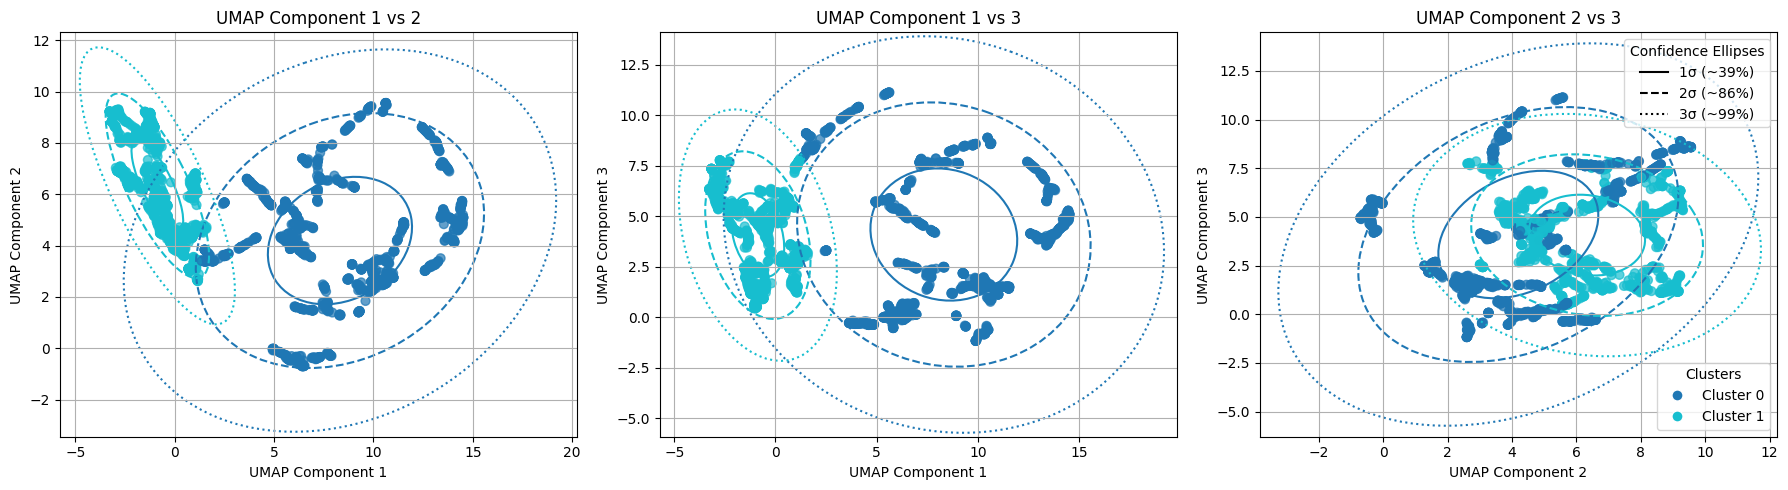

In [252]:
# Define component pairs for plotting
component_pairs = [(0, 1), (0, 2), (1, 2)]
titles = [
    "UMAP Component 1 vs 2",
    "UMAP Component 1 vs 3",
    "UMAP Component 2 vs 3"
]

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, colors):
    from scipy.stats import chi2

    std_levels = [1, 2, 3]
    chi2_vals = [chi2.ppf(0.3935, df=2), chi2.ppf(0.8647, df=2), chi2.ppf(0.9889, df=2)]
    scales = [np.sqrt(val) for val in chi2_vals]

    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        if covar.ndim == 1:  # spherical
            cov = np.diag(covar)
        elif covar.ndim == 2:  # full or tied
            cov = covar
        else:
            continue

        # Project to 2D
        sub_cov = cov[np.ix_([comp_x, comp_y], [comp_x, comp_y])]
        sub_mean = mean[[comp_x, comp_y]]

        # Eigen decomposition
        vals, vecs = np.linalg.eigh(sub_cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        for scale, std in zip(scales, std_levels):
            width, height = 2 * scale * np.sqrt(vals)

            if std == 1:
                linestyle = '-'
            elif std == 2:
                linestyle = '--'
            else:
                linestyle = ':'

            ellipse = Ellipse(
                sub_mean, width, height, angle=theta,
                edgecolor=colors[i], facecolor='none', lw=1.5, linestyle=linestyle
            )
            ax.add_patch(ellipse)


# Define colors for ellipses
colors = plt.cm.tab10(np.linspace(0, 1, K))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (comp_x, comp_y) in enumerate(component_pairs):
    ax = axes[i]
    scatter = ax.scatter(
        X_umap[:, comp_x], X_umap[:, comp_y],
        c=gmm_labels, cmap='tab10', s=40, alpha=0.7
    )
    ax.set_xlabel(f'UMAP Component {comp_x + 1}')
    ax.set_ylabel(f'UMAP Component {comp_y + 1}')
    ax.set_title(titles[i])
    ax.grid(True)

    # Plot GMM ellipses
    plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, colors)

# Add legend to the last plot
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=1.5, linestyle='-'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
    Line2D([0], [0], color='black', lw=1.5, linestyle=':')
]
confidence_legend = axes[-1].legend(custom_lines, ['1σ (~39%)', '2σ (~86%)', '3σ (~99%)'], loc="upper right", title="Confidence Ellipses")

# Add first legend for confidence ellipses
axes[-1].add_artist(confidence_legend) 

# Create second legend for clusters
cluster_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=colors[i], markersize=8)
    for i in range(K)
]
cluster_legend = axes[-1].legend(handles=cluster_handles, loc='lower right', title="Clusters")


plt.tight_layout()
plt.show()

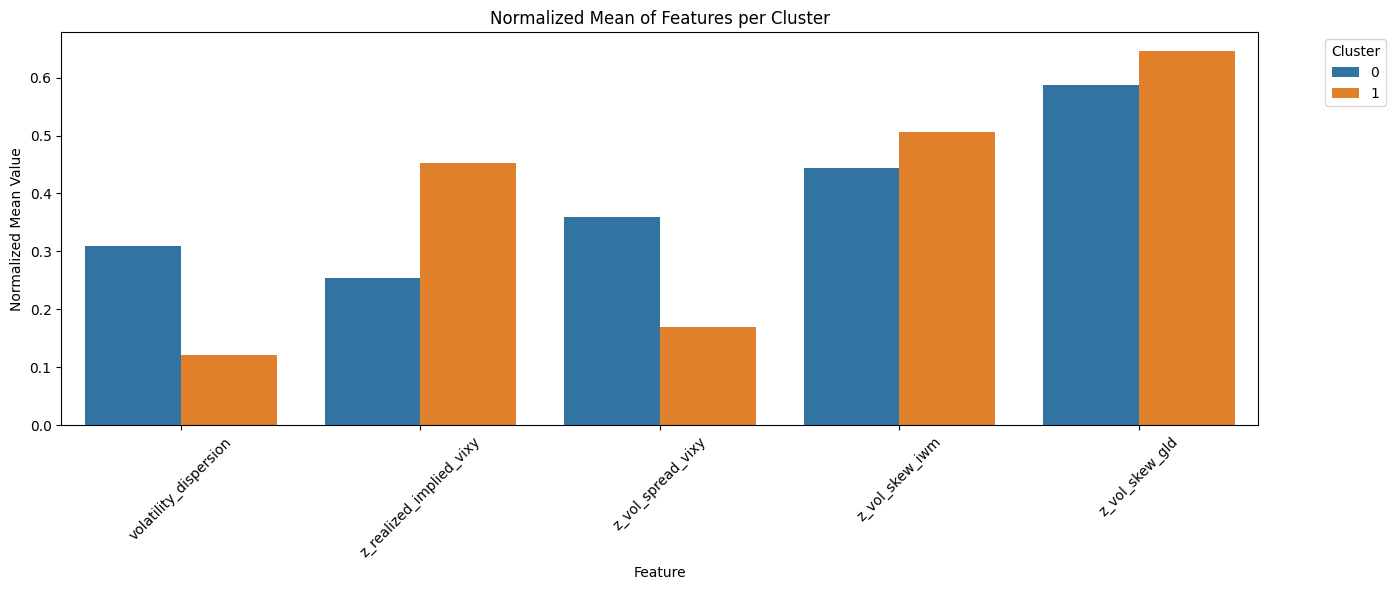

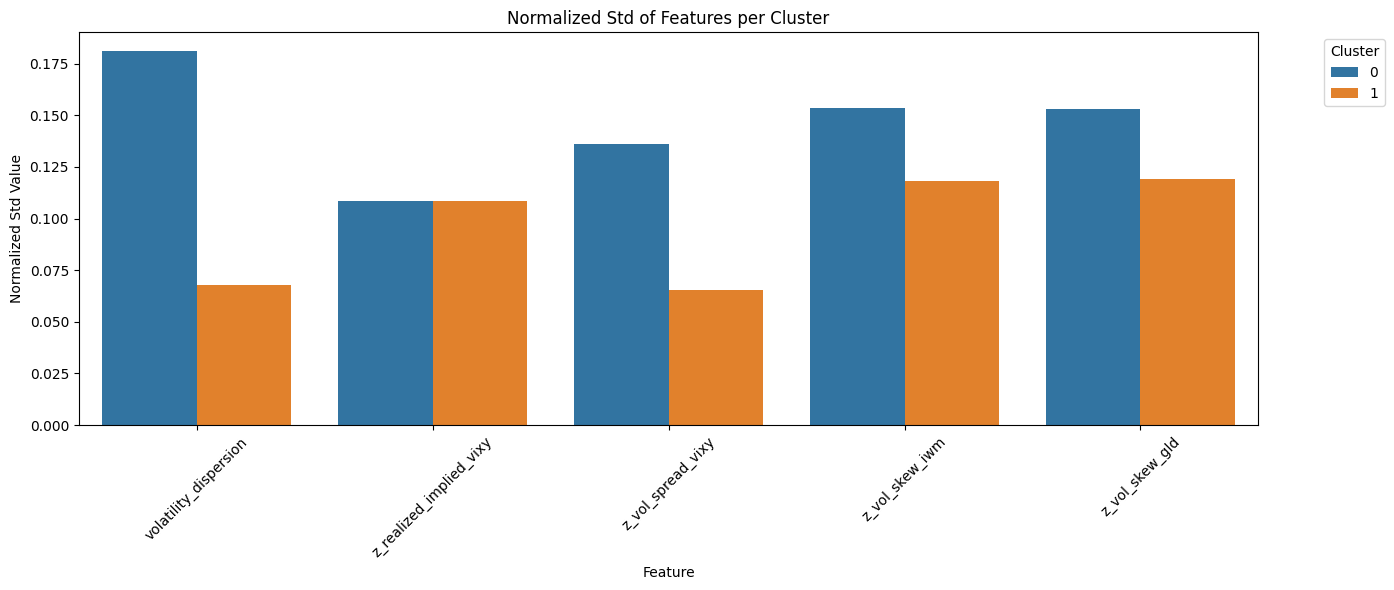

In [253]:
import seaborn as sns

df_normalized = pd.DataFrame(scaled, columns=df_stationary.columns, index=df_stationary.index)

# Assign cluster labels
df_normalized['Cluster'] = gmm_labels

# Calculate mean value per feature per cluster
mean_per_cluster = df_normalized.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Normalized Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 6))
sns.barplot(x='Feature', y='Normalized Mean', hue='Cluster', data=melted, palette='tab10')

plt.title('Normalized Mean of Features per Cluster')
plt.xlabel('Feature')
plt.ylabel('Normalized Mean Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate std value per feature per cluster
std_per_cluster = df_normalized.groupby('Cluster').std().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = std_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Normalized Std')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(14, 6))
sns.barplot(x='Feature', y='Normalized Std', hue='Cluster', data=melted, palette='tab10')

plt.title('Normalized Std of Features per Cluster')
plt.xlabel('Feature')
plt.ylabel('Normalized Std Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


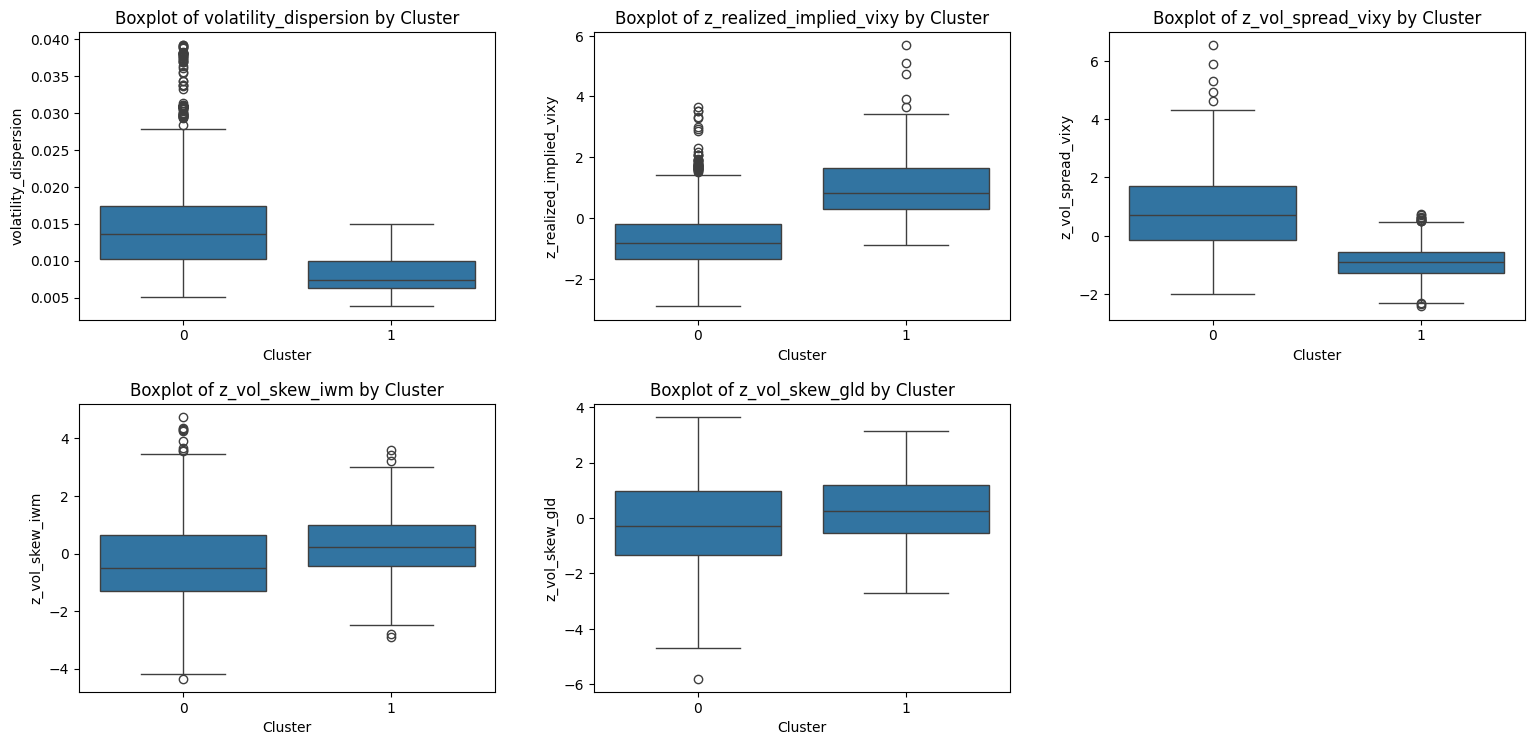

In [254]:
import seaborn as sns
import math

# Assign cluster labels to the original data
df_clustered = df_stationary.copy()
df_clustered['Cluster'] = gmm_labels

# Create boxplots: one subplot per feature in a grid (2 cols)
num_features = df_stationary.shape[1]
ncols = 3
nrows = math.ceil(num_features / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
fig.tight_layout(pad=4.0)

# Flatten axes array for easy iteration
axs = axs.flatten()

for i, column in enumerate(df_stationary.columns):
    sns.boxplot(x='Cluster', y=column, data=df_clustered, ax=axs[i])
    axs[i].set_title(f'Boxplot of {column} by Cluster')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(column)

# Hide any empty subplots if the number of features is odd
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()


In [255]:
# Print percentage of data points in each cluster
cluster_counts = pd.Series(gmm_labels).value_counts(normalize=True) * 100
print("\n Percentage of data points in each cluster:")
for cluster_id, percentage in cluster_counts.sort_index().items():
    print(f"Cluster {cluster_id}: {percentage:.2f}%")


 Percentage of data points in each cluster:
Cluster 0: 54.96%
Cluster 1: 45.04%


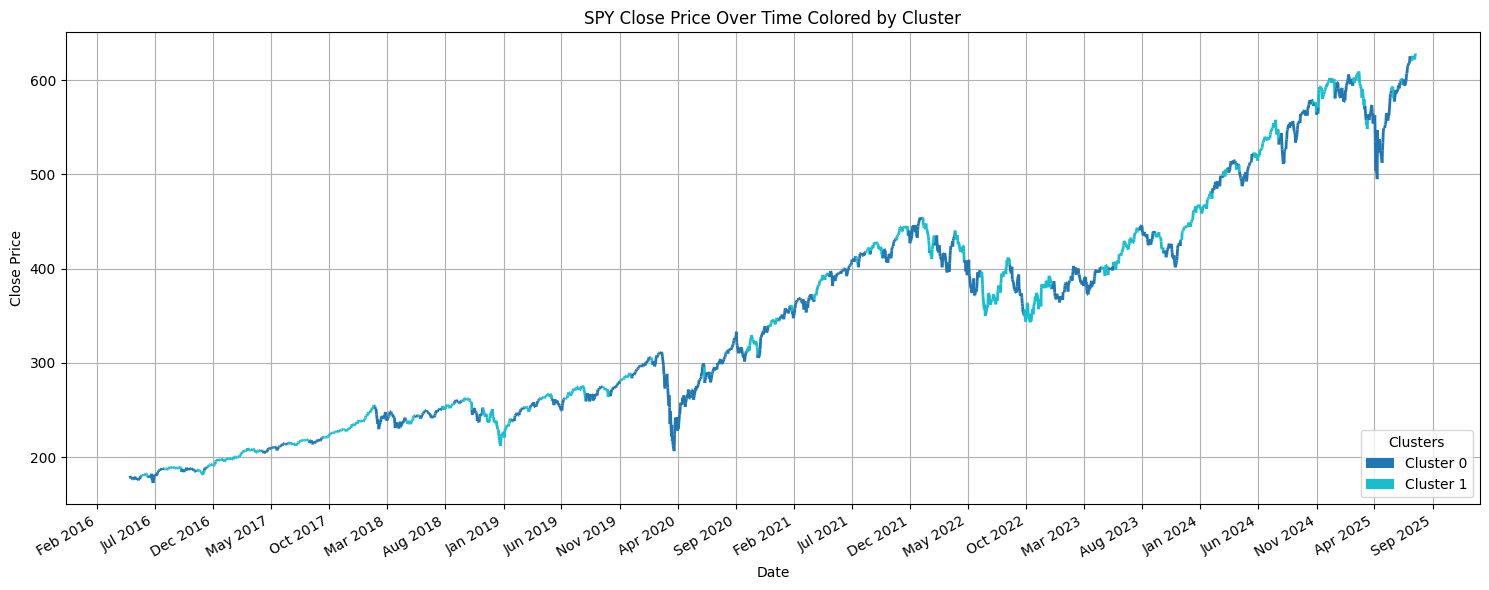

In [256]:
req = StockBarsRequest(
    symbol_or_symbols = 'SPY',
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_2_plot = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_2_plot = df_2_plot.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs
# remove first days that do not have cluster
df_2_plot =  df_2_plot[nan_range_start:]

from matplotlib.collections import LineCollection

# Merge cluster labels into df_2_plot
df_with_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = df_stationary.copy()
df_time_clustered['Cluster'] = gmm_labels
df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

df_with_clusters['Cluster'] = df_time_clustered.loc[df_2_plot.index, 'Cluster'].values

# Prepare data for colored line segments
dates = df_with_clusters.index
close_prices = df_with_clusters['close'].values
clusters = df_with_clusters['Cluster'].values

# Create line segments between consecutive points
points = np.array([dates, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Assign colors based on clusters (normalize for color mapping)
colors = clusters[:-1]  # Use starting point's cluster for each segment
cmap = plt.get_cmap("tab10")  # Choose a categorical colormap
norm = plt.Normalize(min(clusters), max(clusters))

import matplotlib.dates as mdates
# Convert datetime index to Matplotlib's float format
date_nums = mdates.date2num(dates)
# Create line segments with numeric date values
points = np.array([date_nums, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(colors)
lc.set_linewidth(2)

# Plot with colored lines for clusters using LineCollection
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc)
ax.autoscale()
ax.set_title("SPY Close Price Over Time Colored by Cluster")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.grid(True)

# Format month and year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

fig.autofmt_xdate()  # Auto-rotate labels for better visibility

# Build a legend for discrete clusters
unique_clusters = np.unique(clusters)
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters]
ax.legend(handles=legend_elements, loc="lower right", title="Clusters")


plt.tight_layout()
plt.show()